In [1]:
# imports

from collections import Counter
import heapq
from bitarray import bitarray

import pandas as pd
import numpy as np
import math

from PIL import Image

import os
os.environ["PATH"] += os.pathsep + 'C:/Users/PC/anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin/graphviz'
import graphviz
from graphviz import Digraph
from matplotlib import pyplot as plt

import filecmp
import ast

import time
import timeit

from huffman import Huffman
from LZ77 import LZ77Compressor

# Abstract

### Research goals

This research is focused on the Huffman compression algorithm, its implimentation in Python programming language, comparrison between Huffman algorithm and LZ77.

### History

   In 1951, David Huffman had the task to find the most efficient binary code for his final exam paper, he thought of the idea to use frequency-sorted binary tree, building it from bottom to top, which guaranteed optimality.It was published in the 1952 paper "A Method for the Construction of Minimum-Redundancy Codes".
    
### Brief description

   Huffman code is a type of [prefix code](https://en.wikipedia.org/wiki/Prefix_code#:~:text=A%20prefix%20code%20is%20a,code%20word%20in%20the%20system), which is used for lossless data compression.The idea is to assign variable-length codes to input characters, lengths of the assigned codes are based on the frequencies of corresponding characters. The most frequent character gets the smallest code and the least frequent character gets the largest code. It is usefull to compress data when there are frequently occuring characters and is still widely used to this day.
    


## Difference between lossless and lossy compression.


However, before we dive deeper into the world of compression algorithms, lets take a look at the difference between two types of compressions:
     
 * Lossless
 * Lossy

The main thing is that the **Lossless compression**, restores the files to its original form without loosing data, on the other hand, the **Lossy compression** looses some data in order to compress the file. The data that is lost is so noticable.Here is a nice table giving the differences:


|                     | Lossless Compression                        | Lossy Compression                            |
|---------------------|---------------------------------------------|----------------------------------------------|
| Data Elimination    | No                                          | Yes                                          |
| Restore to original | Yes                                         | No                                           |
| Quality             | Better                                      | Worse                                        |
| Size reduction      | Less                                        | More                                         |
| Capacity            | Less                                        | More                                         |
| Uses                | Text, images, audio                         | Audio, video, images                         |
| Algorithms          | Huffman coding, Run length encoding, ect... | Transform coding, Fractal compression, ect.. |

After we understood the main differences between the two techniques, it is time to write some simple code, to check some of the properties that they have.

Lets now compress an image with exmples from both methods. Actually I am pretty sure that you have already used those two techniques without even knowing it. **PNG** and **JPEG** are perfect examples of that, where **JPEG** is lossy compression and **PNG** is lossless compression. We will write simple program that will convert an image from PNG to JPEG and vise versa, we will check the size and the resolution of the images as well. Here is the image:

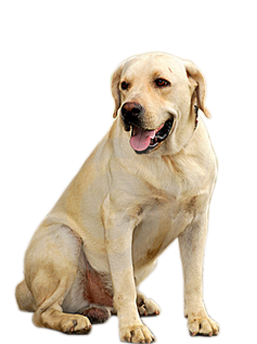

In [2]:
def png_jpeg_and_around(image):
    """
    Takes a PNG and converts it to JPEG and vise versa.
    Prints the sizes of the original image the new JPEG image and the new PNG image
    """
    image_png_original = Image.open(image)
    image_jpeg = image_png_original.convert('RGB')
    
    image_jpeg.save("dogJPEG.jpg")
    
    image_png = Image.open("dogJPEG.jpg")
    image_png.save("dogPNG.png")
    
    original_png_image_size = os.path.getsize("pictures/doggo.png")
    new_png_image_size = os.path.getsize("pictures/dogPNG.png")
    new_jpeg_image_size = os.path.getsize("pictures/dogJPEG.jpg")
    
    print(f"The original PNG image size: {original_png_image_size} bytes\n"
            f"The new PNG image size:  {new_png_image_size} bytes\n"
            f"The new JPEG image size: {new_jpeg_image_size} bytes\n")
  
        
    

In [3]:
png_jpeg_and_around("pictures/doggo.png")

The original PNG image size: 108625 bytes
The new PNG image size:  93858 bytes
The new JPEG image size: 13338 bytes



#### The new JPEG image:

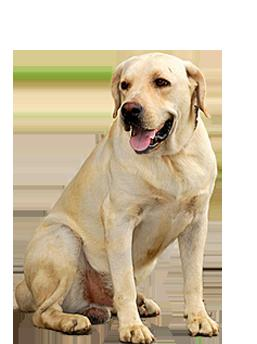


#### The new PNG image:

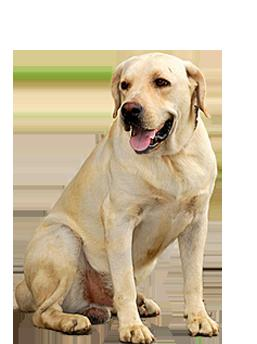

As you can see the image hasn't changed at all except that we added background, however the sizes of the files are quite different. The original image size is 106 Kb and the **JPEG** size is only 13 KB. When we transformed again from **JPEG** to **PNG** the size changed as well to 91,6 KB, which is not the same size as the original image, this is due to lossy compression losses.

## But.. how much is enough ? 

 The above experiment showed us how much we can compress an image without loosing it. However when we are talking about loseless algorithms and their optimization we tend to ask well how much we can compress a file without loosing information. To answer this question the Shannon's source coding theorem or noiseless coding theorem is giving us a hand. It establishes the limits to possible data compression, and the operational meaning of the Shannon entropy.
 
### Shannon entropy

The entropy is formally defined as:

$$H(X)=-\sum_{i=0}^{n}P(x_{i})log_bP(x_{i})$$

Where : 

* $ \sum_{i=0}^{n} $ is a summation for probabilities from $i$ to $n$



* $ P(x_{i}) $ is the probability of a single event


* $ b $ is the base of the logarithm used. Some commonlly used values are $2$ for bits Euler's number $e$ for nats and $10$ for bans

For our purpose we are going to use this variation of the formula for calculation the optimum compress size:

$$H(A)=-\sum_{w_{i}>0}w_ih(a_i)$$

where $$ h(a_i) = log_2\frac{1}{w_i}$$

* $h$ is the information content of each symbol $a_i$ with non-null probability and $w$ is weight.

Formula: 

$$ H(A)=-\sum_{w_{i}>0}w_ih(a_i) = \sum_{w_{i}>0}w_ilog_2\frac{1}{w_i} = - \sum_{w_{i}>0}w_ilog_2w_i$$


### Entropy Calculator

Ok, so now we now how to calculate what is the minimal number of bit per symbol that we need to encode information lets make function that does it for us.

In [4]:
def entropy_calculator(text, base=2, prob = False):
    """
    Takes string as an input and returns entropy.
    Defaut value of base is 2 for bits
    """
    probabilities = [n/len(text) for x,n in Counter(text).items()]
    
    entropy = [-p*math.log(p,2) for p in probabilities]
    
    if prob: 
        return round(sum(entropy),2),probabilities
    else:
        return round(sum(entropy),2)
    

Lets check what is the entropy of the string : "Shanon Entropy"

In [5]:
entropy_calculator("Shanon Entropy")

3.32

We now know that every character can be compressed to 3.32 bits in this string for optimallity.

## Dive deeper into Huffman algorithm

### Huffman tree

Now let's explore the Huffman algorithm a little more. To see how it actually works and why it is so popular. We have this data, each character occupies 8 bits so in total we have $(12 + 7 + 6 + 10) * 8 = 280$ bits.

| Value     | A     | B     | C     | D     |
|-----------|-------|-------|-------|-------|
| Frequency | 12     | 7     | 6     | 10    |




* The first thing that we need to do is to rearange all the values in ascending order of the frequencies.



| Value     | C     | B     | D     | A     |
|-----------|-------|-------|-------|-------|
| Frequency | 6     | 7     | 10     | 12    |



* Second we need to take the first two elements with smalles frequency - in our case those would be C and B.



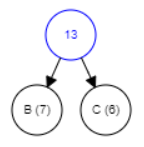

The table will look like this : 

| Value     | CB     | D     | A     |
|-----------|-------|-------|-------|
| Frequency | 13     | 10     | 12    |


* After that we need to complete the same step as many times as needed, now we will take again the first and the second value
with the smallest frequencies.


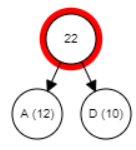

This is the table :


| Value     | CB     | DA     |
|-----------|-------|-------|
| Frequency | 13     | 22    |

* And yet again we combine the values until we get the full tree.

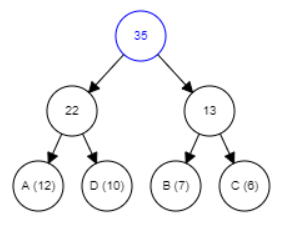

* Now we will assign 0 to left edge and 1 to the right to get this:


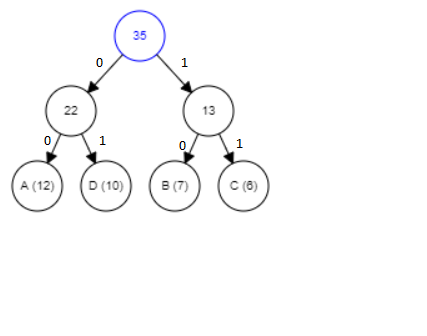

### What is the the size of the string after encoding ?

Take a look at the following table to see what is the size after the compression:


| Character     | Frequency | Code   | Size     |
|---------------|-----------|--------|----------|
| A             | 4         | 00     | 4*2=10   |
| B             | 5         | 10     | 5*2=10   |
| C             | 7         | 11     | 7*2=14   |
| D             | 10        | 01     | 10*2=20  |
| 4*8 = 32 bits | 16 bits   |        | 54 bits  |

We have a total of  $32+16+54 = 102 $ bits, so actually we managed to compress the string with 36 % which is pretty good.

After we understood how to compress files it will be a good idea to know how to decompress them as well. It is very simple we need to traverse from the root of the tree. As we figured out the code for the A characters on our string is $00$ , so if we look at the tree we can see how the traversal is done. Same applies with the other characters as well.


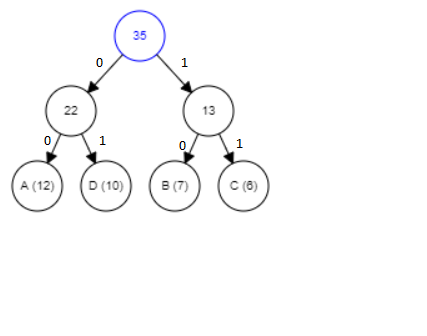

### Formal description

$A = (a_1,a_2,...,a_n)$ is the character symbol of the size $n$.

$W = (w_1,w_2,...,w_n)$, which is  positive symbol weights i.e $w_i =$ **weight** $(a_i),i \in \{1,2,...,n\}$.

The output is:

$C(W) = (c_1,c_2,...,c_n)$ which is the binary code for a character , where $c_i$ is the codeword for $a_i, i \in \{1,2,...,n\}$.

Our goal is:

Let $L(C(W)) = \sum_{i=1}^{n}w_i$ **weight** $(c_i)$ be the weighted path lenght for the binary code $C$. Condition : $L(C(W)) \leq L(C(T))$ for any code $(T(W))$

It is really important to mention that we need our binary code to be uniquely decodeable, so the sum of probabillity budgets needs to always be less or equal to one. If it is not we can always add extra symbols to make the code complete while keeping it biunique.
To see how optimal the result can be we can compute $L$ and compare it to the Shanon entropy $H$, that we discussed above.


### How to store the data

So far we have a basic idea of the Huffman coding and how to make it, however we need to store the encoded data. The data is stored in binary files. The file is going to be of two parts the header information and the encoded text. Because the encoded text will be something like this : $1000110011$, and we are allowed to write to a file a byte or 8 bits at a time, we need to be sure that the encoded text is devisable by 8, if it is not we will add additional 0s to the encoded text so that we can store the data to the file.In the header information we must include the tree , so that we can decode the encoded text when we decompress the file. We can achieve greater compression if in the header we use 0 and 1, to distinguish between non-leaf and leaf. You are going to see implimenttation on that further down below.

## Building the Huffman algorithm

Now it is time to write our python implementation of the code. 
This is how we are going to proceed with the algorithm:

### Compression

1. We will make a character frequency counter.
2. We are going to make a priority queue.
3. Building the Huffman Tree.
4. Encoding the text.
5. Encoding the tree.
6. Combining the encoded tree and the encoded text togheter and add padding.
7. Writing it to .bin file with header information.

### Decompression

1. Open file and read it.
2. Remove the additional padding.
3. Decoding the tree.
4. Decoding the text. 
5. Write text to new file.


### Additional 

1. Tree visualization.
2. Table visualization.
3. Sizes of compressed vs uncompressed file.
4. Compression ratio.
5. Speed of compression.
6. Comparing entropy to weighed path length.

## Compression

### Counting the character frequency


So basically what are we doing here is that we are counting the frequency of the individual characters and then arranging them into ascending order.

In [6]:
def get_character_frequency(text):
    """Function that takes text as input and returns all unique characters in dictionary in ascending order"""
    unique_chars_freq = Counter([chars for chars in text])
    unique_chars_freq = dict( sorted(unique_chars_freq.items(),key=lambda item: item[1]))
    return unique_chars_freq

### Making the priority queue with heapq

Here we are  going to make a class called `HeapNode`. It is going to serve us as base building block for making the tree nodes.
In the next function called `make_heap` we are going to push the heaps into a list to store them.We are using the heapq python library - basically it provides implementation of the heap queue algorithm. You can get more information [here](https://docs.python.org/3/library/heapq.html#module-heapq).

In [7]:
class HeapNode:
    """Class for building the pririty queue. Takes character, frequency left and right. Returns compared values,
    when building the priority queue"""
    def __init__(self, character, frequency = 0, left = None, right=None):
        self.character = character
        self.frequency = frequency
        self.left = left
        self.right = right
        
    def __lt__(self,other):
        return self.frequency < other.frequency
    
heap = []


def make_heap(frequency):
    """function which is pushing heaps from class HeapNode to heap list"""
    for f in frequency:
        node = HeapNode(f, frequency[f])
        heapq.heappush(heap, node)



### Building the huffman tree

We are going to make a new function called `build_huffman_tree()`. It takes left and right node from the heap list we created earlier and combines them together. Returning the tree. 

In [8]:

def build_huffman_tree():
        """Function that build the Huffman tree. Merges all the nodes into one and return one node value"""
        while len(heap) > 1:
            left = heapq.heappop(heap)
            right = heapq.heappop(heap)
            root = HeapNode(None,frequency=left.frequency + right.frequency)
            root.left = left
            root.right = right
            heapq.heappush(heap, root)
        huffman_tree = heapq.heappop(heap)
        return huffman_tree


### Encoding the Huffman tree so that we can store it in header

This function checks if the if there is a node character or not if there is it gets the acii values of the character and converts it to binary. If there is not character, we call again our function recursively.

In [9]:
def huffman_tree_encoding(tree, current_code):
    """Function that encodes the Huffman tree and returns its binary value"""
    if tree.character is not None:
        current_code += "1"
        current_code += f"{ord(tree.character):08b}"
    else:
        current_code += "0"
        current_code = huffman_tree_encoding(tree.left, current_code)
        current_code = huffman_tree_encoding(tree.right, current_code)

    return current_code



### Making the binary codes for characters

Now, we need to define two functions `make_binary_codes()` and `make_binary_codes_helper()`. In `make_binary_codes()`, we are calling two functions the first one is `make_binary_codes_helper()` and the second one is `huffman_tree_encoding(node, encoded_tree)`, because we need our tree for both. In `make_binary_codes_helper()` we are doing basically the same we did when we encoded the Huffman tree however this time we are adding the binary values of the letters to a dictionary called `codes`.

In [10]:
codes = {}

def make_binary_codes_helper(tree, current_code):
    """A helper function for make_binary_codes_function. Adds binary values of characters to dictionary"""
    if(tree == None):
        return

    if(tree.character != None):
        codes[tree.character] = current_code
        return
    
    make_binary_codes_helper(tree.left, current_code + "0")
    make_binary_codes_helper(tree.right, current_code + "1")


def make_binary_codes(huffman_tree):
    """A function that calls make_codes_helper and huffman_tree_encoding.
    Returns the encoded tree"""
    
    current_code = ""
    
    make_binary_codes_helper(huffman_tree, current_code)


### Encoding the text.

In [11]:
def get_encoded_text(text):
    """Function that takes text as param and returns encoded text"""
    encoded_text = ""
    for character in text:
        encoded_text += codes[character]
        
    return encoded_text


### Combine and add padding

We are combinig the tree, the encoded text and adding padding to it so that it can assure it can be divisible by 8. Padding is added if there is need of it. We add the number of padding in the beggining of the encoded text.

In [12]:
def combine(encoded_text,encoded_tree):
    """Function combining the encoded_tree and the encoded_text.
    Adds padding if needed.
    Returns a string of combined elements"""
    
    padding_number = 8 - (len(encoded_text) + len(encoded_tree)) % 8
    if padding_number != 0:
        encoded_text = padding_number * "0" + encoded_text
        
    return f"{encoded_tree}{padding_number:08b}{encoded_text}"


### Writing the text to output file

Here we are going to write the our encoded tree and text to a bin file. We are making a `bytearray()` objects and append the binary digits by 8 bits at a time.

In [13]:
def compress():
    """Save encoded text to output file"""
    start_time = time.perf_counter ()
    
    with open("sample text/sample-text-file-4kb.txt") as in_file, \
    open("compressed/compressed-sample-text-file-4kb.bin", "wb") as out_file:
        text = in_file.read()
        
        encoding,tree,freq = run_compress(text)
        
        byte_array = bytearray()
        for i in range(0, len(encoding), 8):
            byte_array.append(int(encoding[i:i+8], 2))

        out_file.write(byte_array)
        
        end_time = time.perf_counter ()
    
    total_time = end_time -start_time
 
    return tree,freq,total_time
        
def run_compress(text):
    """Helper function loading for compress""" 
    freq = get_character_frequency(text)
    make_heap(freq)

    tree = build_huffman_tree()

    encoded_tree = huffman_tree_encoding(tree,"")

    make_binary_codes(tree)

    encoded_text = get_encoded_text(text)

    encoded_text_and_header = combine(encoded_text,encoded_tree)
    
    return encoded_text_and_header,tree,freq


## Decompression

### Reading the file


A function that decompresses the file and writes it to output file. `{bin(ord(byte))[2:]:0>8}` - `bin` - returns the values of the unicode representation of `byte`, because python puts `0b` infront of every byte it reads we remove it with `[2:]` and lastly `:0>8` checks if it has 8 bits if not - it appends 0 to it to read the whole byte. 

In [14]:
def decompress():
    """Save decoded text to output file"""
    start_time = time.perf_counter ()
    with open("compressed/compressed-sample-text-file-4kb.bin", "rb") as in_file, \
    open("decompressed/decompressed-sample-text-file-4kb.txt", "w") as out_file:
        encoded_text = ""

        byte = in_file.read(1)
        while len(byte) > 0:
            encoded_text += f"{bin(ord(byte))[2:]:0>8}"
            byte = in_file.read(1)
            
        decoded_text = decode(encoded_text)
        out_file.write(decoded_text)
        
    end_time = time.perf_counter ()
    total_time = end_time - start_time
    return total_time

### Decoding the tree

This functions takes the whole encoded text and extracts the tree. We are checking every bit and delete it because we do not not the lenght of it and check it. If it is $1$ there is a node and we extract the specifict character and save it to our `HeapNode` function we call it recursively to extract the whole tree.   

In [15]:
def huffman_tree_decoding(tree_code):
    """Decoding huffman tree to be able to decode the encoded text"""
    code_bit = tree_code[0]
    del tree_code[0]

    if code_bit == "1":
        char = ""
        for _ in range(8):
            char += tree_code[0]
            del tree_code[0]

        return HeapNode(chr(int(char, 2)))

    return HeapNode(None, left=huffman_tree_decoding(tree_code), right=huffman_tree_decoding(tree_code))

### Removing the padding

We are removing the padding that we added when encoding. We read how many $0$ we have added when padding and removing them.

In [16]:
def remove_padding(encoded_text_with_padding):
    
    number_of_extra_zeros_bin = encoded_text_with_padding[:8]
    encoded_text_with_padding = encoded_text_with_padding[8:]
    number_of_extra_zeros = int("".join(number_of_extra_zeros_bin), 2)
    encoded_text_no_padding = encoded_text_with_padding[number_of_extra_zeros:]

    
    return encoded_text_no_padding

### Decoding the text

In this fucntion we are going to combine `huffman_tree_decoding()` and `remove_padding()` together and will decode the text based on the tree we have encoded.

In [17]:

def decode(encoded_text):
    """Returns decoded string"""

    encoded_text_list = list(encoded_text)
    encoded_tree = huffman_tree_decoding(encoded_text_list)
    
    encoded_tect_no_padding = remove_padding(encoded_text_list)

    text = ""
    current_node = encoded_tree
    for char in encoded_tect_no_padding:
        current_node = current_node.left if char == '0' else current_node.right

        if current_node.character is not None:
            text += current_node.character
            current_node = encoded_tree

    return text


### Testing

Lets make a test to see if everything works correctly so far.

In [18]:
def test():
    """Checks if original file is the same as decompressed."""
    tree,freq,compress_time = compress()
    decompress_time = decompress()
    check_original_decompressed_file = filecmp.cmp('sample text/sample-text-file-4kb.txt',\
                                                   'decompressed/decompressed-sample-text-file-4kb.txt')
    return check_original_decompressed_file,tree,freq,compress_time,decompress_time

Now we are going to assign some variables to our test function to help us with the implimentation of the additional features.

In [19]:
check, tree, freq, compress_time, decompress_time = test()

Cool, after everything is working, we are going to add some additional features to our program. 

## Adding additional features

### Visualizing Huffman tree

Here we are going to visualize our Huffman tree with graphiviz.The code was taken form [here](https://gist.github.com/chendonghp/a68f9c519799933a9b7b1ca6a5be2ead).

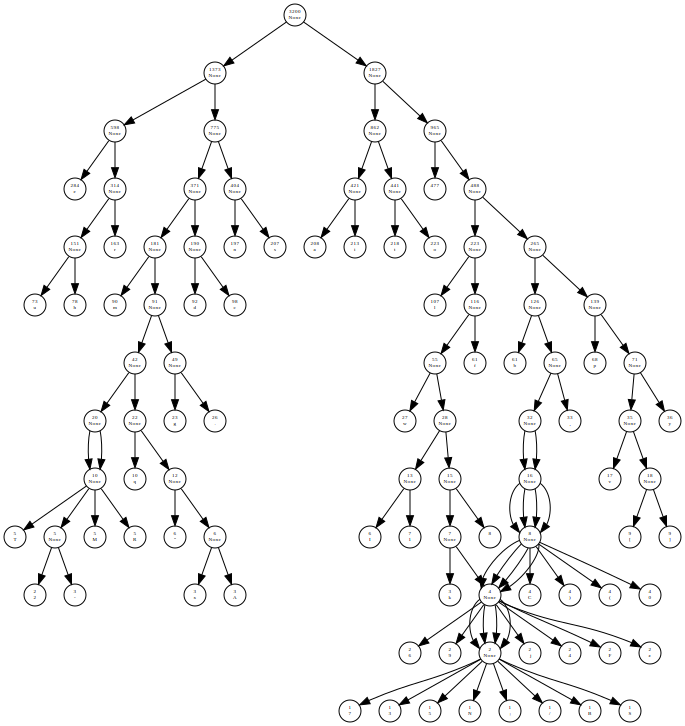

In [20]:

def visualize():
    """A function that visualizes the prebuild Huffman tree"""
    dot = graphviz.Digraph(name='Huffman Tree',node_attr={"fontsize":"5","fixedsize":"True","width":"0.3","height":"0.3"})

    def postorder(tree):
        if tree:
            postorder(tree.left)
            postorder(tree.right)
            dot.node(name=str(tree.frequency)+str(tree.character), label=str(tree.frequency)+'\n'+str(tree.character))
            if tree.left:
                dot.edge(str(tree.frequency)+str(tree.character), str(tree.left.frequency)+str(tree.left.character))
            if tree.right:
                dot.edge(str(tree.frequency)+str(tree.character), str(tree.right.frequency)+str(tree.right.character))

    postorder(tree)
    # render in script
    # dot.render('huffman tree', view=True) 
    return dot
    
visualize()


### Visualizing table with characters, codes and frequencies

Now we are going to make a pandas df to visualize Huffman tabe with its values, codes and frequencies.

In [21]:

def huffman_table(codes,freq):
    """A function that takes the codes and character frequency and returns pandas table with
    values, codes and frequencies"""
    table = pd.DataFrame.from_dict([codes])
    table = table.transpose()
    table = table.reset_index()
    table.columns= ["Value","Code"]
    frequency = []
    for i in table["Value"]:
        for k,v in freq.items():
            if i == k:
                frequency.append(v)

    table["Frequency"] = frequency
    table = table.sort_values(by = "Frequency")
    table.reset_index()
    return table

huffman_table(codes,freq)

,Value,Code,Frequency
47,B,111101011000,1
38,3,111101001001,1
40,5,111101001100,1
41,N,111101001101,1
42,;,111101001110,1
43,/,111101001111,1
48,S,111101011001,1
37,7,111101001000,1
39,j,11110100101,2
31,9,11101011011,2


### Getting the size of compressed vs uncompressed file

This function returns the original and the compressed file size.

In [22]:
def size_comparison( compressed_file_path, original_file_path):
    """Compares the sizes of two files. Returns sizes in bytes"""
    size_compressed_file = os.path.getsize(compressed_file_path)
    size_original_file = os.path.getsize(original_file_path)

    return print(f"Compressed file size : {size_compressed_file} bytes \n" \
                 f"Uncompressed file size : {size_original_file} bytes")

size_comparison("compressed/compressed-sample-text-file-4kb.bin",\
                "sample text/sample-text-file-4kb.txt")

Compressed file size : 1839 bytes 
Uncompressed file size : 3208 bytes


### Compression ratio

Here we calculate the by what percent we have compressed out file and the compression ratio.

In [23]:
def compression_percentage_and_ratio(compressed_file_path, original_file_path):   
    """Takes original file and compressed file sizes. Returns compression percentage and ratio."""
    
    size_compressed_file = os.path.getsize(compressed_file_path)
    size_original_file = os.path.getsize(original_file_path)
    
    percentage_compression = 100 - (size_compressed_file / size_original_file * 100)
    ratio = size_compressed_file / size_original_file
    
    return print(f"Compression percentage : {percentage_compression:.2f}% \n" \
                 f"Compression ratio :  {ratio:.2f}")
    
compression_percentage_and_ratio("compressed/compressed-sample-text-file-4kb.bin",\
                                 "sample text/sample-text-file-4kb.txt")


Compression percentage : 42.67% 
Compression ratio :  0.57


### Compression and decompression time


Get the compression and the decompression time.

In [24]:
def compression_time(compress_time):
    """Returns compression time."""
    return f"Compression time : {compress_time:.4f}"

def decompression_time(decompress_time):
    """Returns decompression time."""
    return f"Decompression time : {decompress_time:.4f}"

compression_time(compress_time),decompression_time(decompress_time)

('Compression time : 0.0028', 'Decompression time : 0.0061')

For simplicity in our further research, I have made a package and already imported it. It is called `huffman.py` and it has only one class called `Huffman`.

# Comparing our Huffman algorithm to LZ77

Now lets compare our Huffman code to LL77, again a lossless compression algorithm.

## About LZ77
Lz77 is a lossless data compression algorithm made in published in papers by Abraham Lempel and Jacob Ziv in 1977.LZ77 algorithms achieve compression by replacing repeated occurrences of data with references to a single copy of that data existing earlier in the uncompressed data stream. A match is encoded by a pair of numbers called a length-distance pair.To spot matches, the encoder must keep track of some amount of the most recent data.The structure in which this data is held is called a sliding window, which is why LZ77 is sometimes called sliding-window compression. The encoder needs to keep this data to look for matches, and the decoder needs to keep this data to interpret the matches the encoder refers to. The larger the sliding window is, the longer back the encoder may search for creating references.Its usefull to allow lengh-distance pairs to specify a length that actually exceeds the distance.[This](https://www.youtube.com/watch?v=zev2A2uWYsM&ab_channel=GeorgiiIvannikov) video explains it well.

Here is a table example with this encoding AABCBBABC:



| Step | Position | Match   | Byte    | Output |
|------|----------|---------|---------|--------|
| 1    | 1        | --      | A       | (0,0)A |
| 2    | 2        | A       | --      | (1,1)  |
| 3    | 3        | --      | B       | (0,0)B |
| 4    | 4        | --      | C       | (0,0)C |
| 5    | 5        | B       | --      | (2,1)  |
| 6    | 6        | B       | --      | (1,1)  |
| 7    | 7        | ABC     | --      | (5,3)  |

And here is example of decompression:

| Step | Position | Match   | Byte    | Output |
|------|----------|---------|---------|--------|
| 1    | 1        | --      | 4*2=10  | (0,0)A |
| 2    | 2        | A       | --      | (1,1)  |
| 3    | 3        | --      | B       | (0,0)B |
| 4    | 4        | --      | C       | (0,0)C |
| 5    | 5        | B       | --      | (2,1)  |
| 6    | 6        | B       | --      | (1,1)  |
| 7    | 7        | ABC     | --      | (5,3)  |

## Comparison

For our implimentation we are going to use the [this](https://github.com/manassra/LZ77-Compressor) implimentation of LZ77 - first result in google.We are going to add our Huffman code as well and we will use sample text files with sizes of 4,20,50,100,500,1000,2000 KB. 

In [25]:
huffman = Huffman()
lz77 = LZ77Compressor(window_size=100)
# gets names of files.
original_file_list = os.listdir("sample text") 
# sorts files by size
original_file_list = sorted( original_file_list,key =  lambda x: os.stat(os.path.join("sample text", x)).st_size) 


### Compression time comparison

Lets first compare the time each of the algorithms needs to compress the files. We are going to make 3 functions. `get_original_file_sizes` returns the file sizes of our sample text documents.`huffman_time` and `lz77_time` are compressing each of the files and returning the combined time.And at the end we will call the functions.

In [26]:
def get_original_file_sizes():
    "Returns the file sizes"
    original_file_sizes = []
    for i in original_file_list:
        original_file_sizes.append(os.path.getsize("sample text/" + i))
    return original_file_sizes

# added break to compress because of LZ77 compression time.


def huffman_compression_time():
    """Returns the total compression time for Huffman code for text file samples."""
    start_time = timeit.default_timer()
    time_huffman = []

    for i,x in enumerate(original_file_list):
        huffman.compress("sample text/" + x)
        time_huffman.append(round(timeit.default_timer()-start_time,4))
        if i == 3:
            break
        
    return time_huffman

def lz77_compression_time():
    """Returns the total compression time for LZ77 code for text file samples."""
    start_time = timeit.default_timer()
    time_lz77 = []

    for i,x in enumerate(original_file_list):
        lz77.compress("sample text/" + x, "compressed lz77/" + x)
        time_lz77.append(round(timeit.default_timer()-start_time,4))
        if i == 3:
            break
        
    return time_lz77


original_file_sizes = get_original_file_sizes()
time_compression_huffman = huffman_compression_time()
time_compression_lz77 = lz77_compression_time()


File was compressed successfully and saved to output path ...
File was compressed successfully and saved to output path ...
File was compressed successfully and saved to output path ...
File was compressed successfully and saved to output path ...


Here, we are making a simple function for plotting. Where `size` are the sizes of our sample files.However we are turning them into KB, because `os.path.getsize` and we plot the time that took for compression for both of our algorithms.

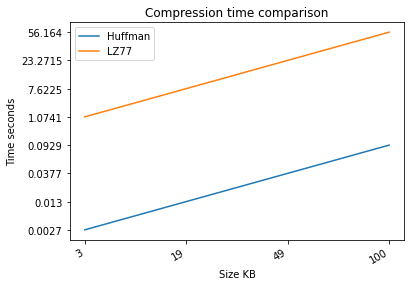

In [27]:
def plot_compression_time_comparison(time_huffman,time_lz77):
    """Plotting function for compression time of for both algorithms.""" 
    size = [round(x/1024) for x in original_file_sizes]
    plt.plot(list(map(str, size[:4])),list(map(str, time_compression_huffman)))
    plt.plot(list(map(str, size[:4])),list(map(str, time_compression_lz77)))
    plt.legend(["Huffman","LZ77"])
    ax= plt.subplot()
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_title('Compression time comparison')
    plt.xlabel("Size KB")
    plt.ylabel("Time seconds")
    plt.show()
plot_compression_time_comparison(time_compression_huffman,time_compression_lz77)

Intresting, so far we can a huge difference in time between the two algorithms where our Huffman algorithm has compressed 100 KB for less than 1 second and LZ77 needs 56 seconds to compress the same file. However, we need to take into consideration that LZ77 is not fully optimized, maybe this is way there is such a hude difference in time.

### Decompression time comparison

Now we are going to see what is the time for decompression for the algorithms.

In [28]:
# added break to decompress because of LZ77 time.

def get_compressed_files_huffman_lz77():
    """Functions that gets the compressed Huffman and Lz77 files names.
    Returns them as lists."""
    
    huffman_compressed_file_list = os.listdir("compressed") 
    huffman_compressed_file_list = sorted( original_file_list,key = \
                                          lambda x: os.stat(os.path.join("compressed", x.replace(".txt",".bin"))).st_size) 
    
    lz77_compressed_file_list = os.listdir("compressed lz77") 
    lz77_compressed_file_list = sorted( original_file_list,key = \
                                       lambda x: os.stat(os.path.join("compressed lz77", x)).st_size)
    
    return huffman_compressed_file_list,lz77_compressed_file_list

def get_compressed_huffman_file_sizes():
    "Returns the file sizes for Huffman"
    compressed_huffman_file_sizes = []
    for i,v in enumerate(huffman_compressed_file_list):
        compressed_huffman_file_sizes.append(os.path.getsize("compressed/" + v.replace(".txt",".bin")))
        if i == 3:
            break
    return compressed_huffman_file_sizes


def get_compressed_lz77_file_sizes():
    "Returns the file sizes for LZ77"
    compressed_lz77_file_sizes = []
    for i,v in enumerate(lz77_compressed_file_list):
        compressed_lz77_file_sizes.append(os.path.getsize("compressed lz77/" + v))
        if i == 3:
            break
    return compressed_lz77_file_sizes
    
    

def huffman_decompression_time():
    """Returns the total compression time for Huffman code for text file samples."""
    start_time = timeit.default_timer()
    time_huffman = []
    
    for i,x in enumerate(original_file_list):
        huffman.decompress("compressed/" + x.replace(".txt",".bin"))
        time_huffman.append(round(timeit.default_timer()-start_time,4))
        if i == 3:
            break
    return time_huffman

# added break because takes too long to decompress
def lz77_decompression_time():
    """Returns the total compression time for LZ77 code for text file samples."""
    start_time = timeit.default_timer()
    time_lz77 = []
    
    for i,x in enumerate(original_file_list):
        lz77.decompress("compressed lz77/" + x, "decompressed lz77/" + x)
        time_lz77.append(round(timeit.default_timer()-start_time,4))
        if i == 3:
            break
    return time_lz77


huffman_compressed_file_list, lz77_compressed_file_list = get_compressed_files_huffman_lz77()

huffman_compressed_size_list = get_compressed_huffman_file_sizes()
lz77_compressed_size_list = get_compressed_lz77_file_sizes()

huffman_decompression_time = huffman_decompression_time()
lz77_decompression_time = lz77_decompression_time()


File was decompressed successfully and saved to output path ...
File was decompressed successfully and saved to output path ...
File was decompressed successfully and saved to output path ...
File was decompressed successfully and saved to output path ...


Plotting the decompression time for Huffman and LZ77 on two graphs.

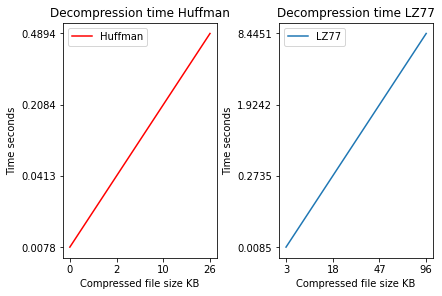

In [29]:
def plot_decompression_time_comparison(time_huffman,time_lz77):
    """Plottoing function for decompression time."""
    
    fig, (ax1, ax2) = plt.subplots(1,2,constrained_layout = True)
    
    size_huffman = [round(x/1024) for x in huffman_compressed_size_list]
    ax1.plot(list(map(str, size_huffman)),list(map(str, huffman_decompression_time)),color="red")
    ax1.legend(["Huffman"])
    ax1.set_title('Decompression time Huffman')
    ax1.set(xlabel='Compressed file size KB', ylabel='Time seconds')
    
    size_lz77 = [round(int(x)/1024) for x in lz77_compressed_size_list]    
    ax2.plot(list(map(str,size_lz77)),list(map(str, lz77_decompression_time)))
    ax2.legend(["LZ77"])
    ax2.set_title('Decompression time LZ77')
    ax2.set(xlabel='Compressed file size KB', ylabel='Time seconds')
    
    plt.show()
    
plot_decompression_time_comparison(huffman_decompression_time,lz77_decompression_time)

From here, we can see the decompression time for LZ77 again is much slower compared to Huffman decompration time and the sizes of each Lz77 compressed file is bigger.

### Size compression comparison

Okay, lets now compare the output file sizes for both algorithms and plot the differences. In `size_compraison()` we are getting the sizes of the compressed files for the algorithms and in `plot_file_sizes` we are plotting them.

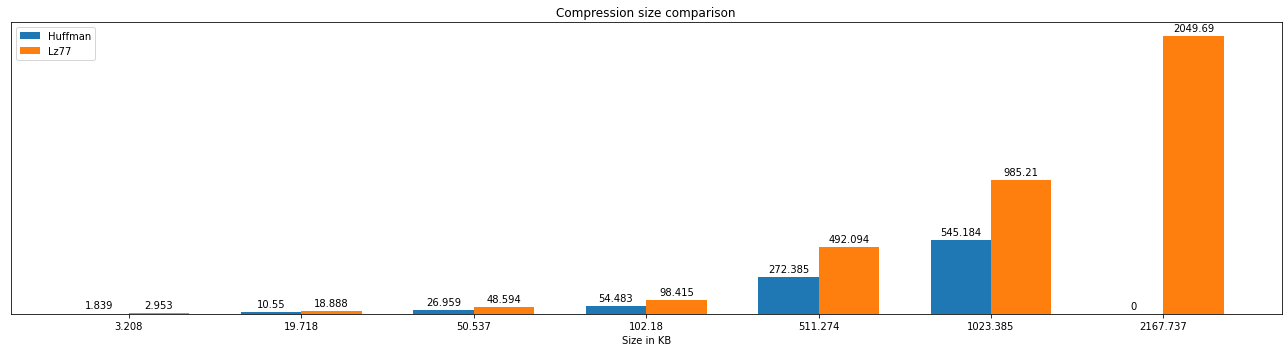

In [30]:
def size_comparison():
    """Function that returns the compressed file sizes for both algorithms as lists."""
    # Huffman
    compressed_huffman_file_sizes = []
    for i in original_file_list:
        compressed_huffman_file_sizes.append(os.path.getsize(f"compressed/{i.replace('.txt','')}.bin"))
                                                             
    # LZ77
    compressed_lz77_file_sizes = []
    for i in original_file_list:
        compressed_lz77_file_sizes.append(os.path.getsize(f"compressed lz77/{i}"))                                                      
                                                             
    return compressed_huffman_file_sizes,compressed_lz77_file_sizes
                                                          
def plot_file_sizes():
    """Plotting function for file sizes comparisson."""
                                                          
    compressed_huffman_file_sizes,compressed_lz77_file_sizes = size_comparison()
    size = [x/1000 for x in original_file_sizes]
    compressed_huffman_file_sizes = [x/1000 for x in compressed_huffman_file_sizes]
    compressed_lz77_file_sizes = [x/1000 for x in compressed_lz77_file_sizes]
    
    x = np.arange(len(size))  # the label locations
    width = 0.35
    # the width of the bars

    fig, ax = plt.subplots(figsize=(18,5))
    rects1 = ax.bar(x - width/2, compressed_huffman_file_sizes, width, label='Huffman')
    rects2 = ax.bar(x + width/2, compressed_lz77_file_sizes, width, label='Lz77')


    ax.set_title('Compression size comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(size)
    ax.legend()
    ax.set_yticks([])
    ax.set_xlabel("Size in KB")
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    
    plt.show()
plot_file_sizes()

Again we can see that our Huffman algorithm compresses the files more than the LZ77's python implimentation. Again I am going to acknowledge that maybe LZ77 is poorly optimized. Lets check the percentage and ratio compression for both algorithms.

Huffman percentage and ratio compression

In [31]:

for c,o in zip(huffman_compressed_file_list,original_file_list):
    huffman.compression_percentage_and_ratio("compressed/"+   c.replace(".txt",".bin"),\
                                         "sample text/"+ o)

Compression percentage : 100.00% 
Compression ratio :  0.00

Compression percentage : 90.67% 
Compression ratio :  0.09

Compression percentage : 79.12% 
Compression ratio :  0.21

Compression percentage : 73.62% 
Compression ratio :  0.26

Compression percentage : 89.34% 
Compression ratio :  0.11

Compression percentage : 73.38% 
Compression ratio :  0.27

Compression percentage : 74.85% 
Compression ratio :  0.25



LZ77 percentage and ratio compression

In [32]:
for c,o in zip(lz77_compressed_file_list,original_file_list):
    huffman.compression_percentage_and_ratio("compressed lz77/"+ c,\
                                         "sample text/"+ o)

Compression percentage : 7.95% 
Compression ratio :  0.92

Compression percentage : 4.21% 
Compression ratio :  0.96

Compression percentage : 3.84% 
Compression ratio :  0.96

Compression percentage : 3.68% 
Compression ratio :  0.96

Compression percentage : 3.75% 
Compression ratio :  0.96

Compression percentage : 3.73% 
Compression ratio :  0.96

Compression percentage : 5.45% 
Compression ratio :  0.95



We can see that the compression ratio and percentage is significantly lower for LZ77.

### Conslusion

So far, we understood how to impliment the algorithm with python, we have compared it with LZ77 and we saw that our Huffman code is doing far better than the python implimentation of LZ77 for this particular data set. Of course, our conclusion is not definite, because there is plenty of room for optimization for both algorithms. We are not going to deny that the two algorithms are the most used compression algorithms of all time.


## Resources


https://stackoverflow.com/questions/11587044/how-can-i-create-a-tree-for-huffman-encoding-and-decoding

https://www.youtube.com/watch?v=JCOph23TQTY&t=901s

https://en.wikipedia.org/wiki/Huffman_coding

https://www.youtube.com/watch?v=NSfIXyEpOjU&ab_channel=SandeepVaid

https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

https://engineering.purdue.edu/ece264/17au/hw/HW13?alt=huffman

https://gist.github.com/chendonghp/a68f9c519799933a9b7b1ca6a5be2ead

https://github.com/shkolovy/huffman-compressor/blob/master/huffman_compressor.py

https://github.com/bhrigu123/huffman-coding/blob/master/huffman.py

https://github.com/manassra/LZ77-Compressor

https://docs.microsoft.com/en-us/openspecs/windows_protocols/ms-wusp/fb98aa28-5cd7-407f-8869-a6cef1ff1ccb